# Identificacion de grupos con los resultados de la prediccion anterior
## Imports

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/home/scidb/HeartRatePatterns/Python"))
from LogisticRegresion import ajustLogisticRegression
from PlotWords import plot_word
from Matrix import convert_matrix
from NMF import generateNMF
import pandas as pd

## Número de componentes por los que se factorizara la tabla segun el resultado anterior

In [2]:
n_components=10

In [3]:
def findpatient(message,table,beats):
    groupsize = table.shape[0]
    deads = sum(table.index.labels[1].tolist())
    percent = -1 if groupsize==0 else deads/groupsize
    if groupsize!=0:
        print(message,"groupsize:%d"%groupsize,"deads:%d"%deads,"percent:{0:.2%}".format(percent),beats)

In [4]:
import psycopg2
def selectPearson(word,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_statement='SELECT patient,deadpatient,p1 FROM wordspearson WHERE word = %s'
#    print(cur.mogrify(select_statement,locals()))
    cur.execute(select_statement,(word,))
    select = {}
    for row in cur :
        patient=row[0]
        select = {'word':word,"pacientes":patient,"porcentaje de muertos":"{0:.2%}".format(row[1]/patient),"correlación":row[2]}
    cur.close()
    conn.close()
    return select

In [5]:
def addValue(key,my_dict):
    if key in my_dict:
        my_dict[key] += 1
    else:
        my_dict[key] = 1
    return my_dict

In [6]:
from operator import itemgetter
def predict_proba(modelnmf,compoT,table):
    predicts = modelnmf.predict_proba(compoT)[:,1]
    beats = list(table)
    sortedBeats = []
    numPred = len(predicts)
    nvals={}
    for i in range(0,numPred):
        word = beats[i]
        sel = selectPearson(word)
        if sel=={}:
            print("palabra no encontrada en pearson:",word)
        cuantosMueren=sel['porcentaje de muertos']+" de "+str(sel['pacientes'])
        sortedBeats.append({'word':beats[i],'predict':predicts[i],'cuantosMueren':cuantosMueren,"correlación":sel['correlación']})
        if predicts[i]>.99 : addValue("99",nvals)
        elif predicts[i]>.90 : addValue("90",nvals)
        elif predicts[i]>.80 : addValue("80",nvals)
        elif predicts[i]>.70 : addValue("70",nvals)
        else: addValue("under",nvals)
    print(nvals)
    return sorted(sortedBeats, key=itemgetter('correlación'), reverse=True)

In [7]:
table = convert_matrix()
survived = table.index.labels[1].tolist()
patients = table.values

(590, 18683)


In [8]:
from sklearn.model_selection import train_test_split
patients_train, patients_test,survived_train, survived_test = train_test_split(patients,survived,test_size=0.2, random_state=42)

In [9]:
modelnmf, nmf, patients_nmf, acurracy,roc_aucNew = generateNMF(patients,survived,n_components=n_components)

acurracy is 77.12%
NMF 10 AUC = 0.5002f


In [10]:
import numpy as np
compoT = np.transpose(nmf.components_)
print("components",nmf.components_.shape)
print("components Transpose",compoT.shape)
print(nmf.reconstruction_err_)

components (10, 18683)
components Transpose (18683, 10)
15835.3559674


In [11]:
sortedBeats = predict_proba(modelnmf,compoT,table)
beatKeys = []
for value in sortedBeats:
    beatKeys.append(value['word'])

{'under': 158, '99': 12, '70': 18417, '80': 69, '90': 27}


In [12]:
#print(sortedBeats[:10])
df = pd.DataFrame(sortedBeats)
df = df.set_index('word')
df = df.sort_values(['predict'], ascending=[False])
df

,correlación,cuantosMueren,predict
word,,,
baba,0.013894,74.55% de 558,1.000000
abab,0.004972,74.46% de 556,1.000000
ababa,-0.026421,74.09% de 548,0.999999
babab,-0.045099,73.71% de 525,0.999997
ababab,-0.022126,74.01% de 504,0.999994
bababa,-0.022303,74.02% de 508,0.999993
ddd,0.120737,81.17% de 223,0.999563
dddd,0.151999,87.20% de 125,0.996476
eee,-0.069023,57.89% de 19,0.996147


Top 5 HeartBeats con mayor probabilidad de muerte según la regresión logística


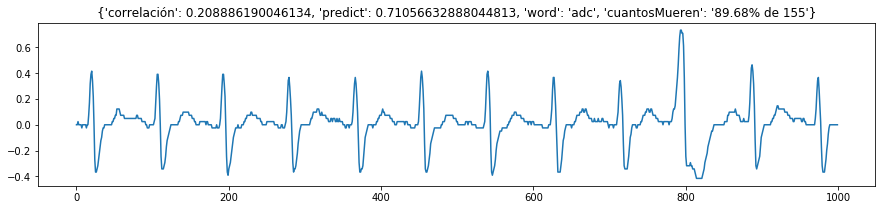

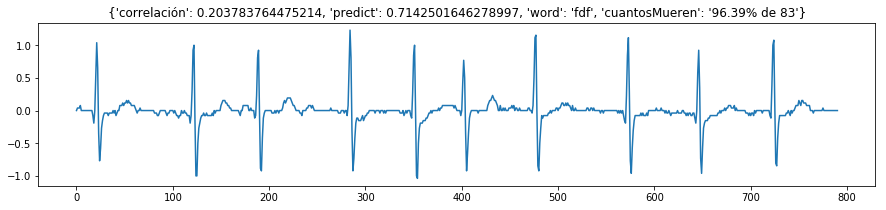

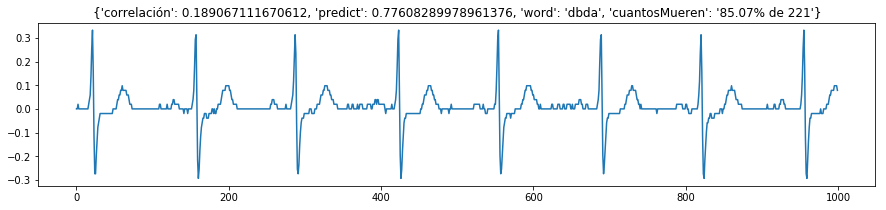

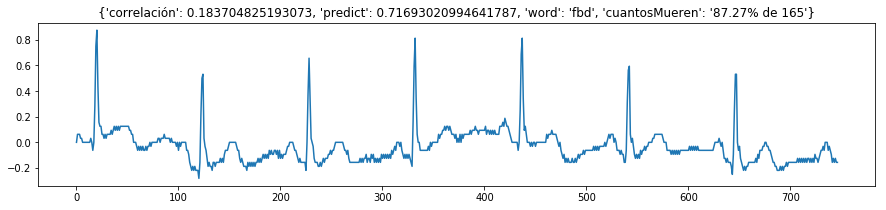

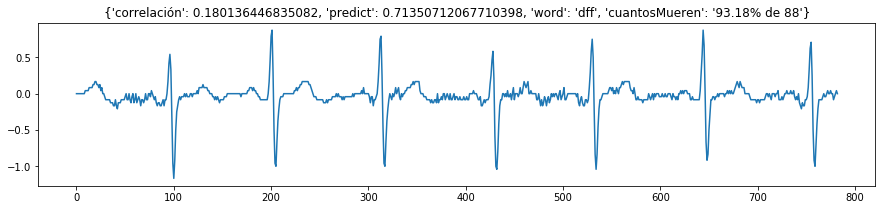

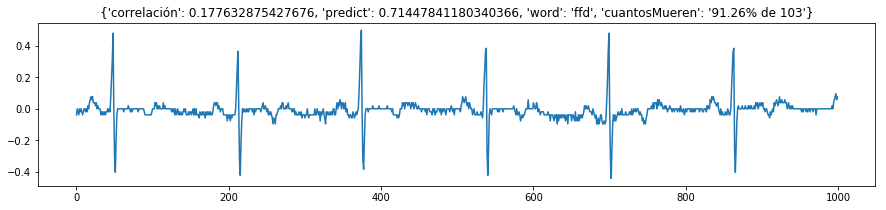

In [13]:
print("Top 5 HeartBeats con mayor probabilidad de muerte según la regresión logística")
plot_word(sortedBeats[:10])

In [14]:
from operator import itemgetter
from scipy.stats.stats import pearsonr
pd.set_option('display.float_format', lambda x: '%.5f' % x)

def find_pearson(value, patient, survived):
    pearsonList = []
    for i in range(value):
        patientpear = patient[:, i]
        pearson = pearsonr(patientpear, survived)
        pearsonList.append({'grupo':i,'correlación':pearson[0],'p-valor':pearson[1]})
    return sorted(pearsonList, key=itemgetter('correlación'), reverse=True)

sortedList = find_pearson(n_components,patients_nmf,survived)
df = pd.DataFrame(sortedList)
df = df.set_index('grupo')
df = df.sort_values(['correlación'], ascending=[False])
df

,correlación,p-valor
grupo,,
3,0.08481,0.03946
9,0.07770,0.05928
7,0.03761,0.36181
4,0.03458,0.40180
6,-0.01957,0.63514
1,-0.02561,0.53467
5,-0.03617,0.38051
2,-0.04098,0.32041
8,-0.06919,0.09314


In [15]:
def print_top_words(components,feature_names,topic_index=None):
    result = []
    for topic_idx, topic in enumerate(components):
        features = [{"word":feature_names[i],"correlación":topic[i]} 
                    for i in topic.argsort()[:-1] if topic[i] > 0]
        if features!=[] and (topic_index==None or topic_index==topic_idx): 
            result.append({"topic":topic_idx,"features":features})
    return result

In [16]:
columns = list(table)
topword = print_top_words(nmf.components_, columns,topic_index=sortedList[0]['grupo'])[0]['features']
subwords = []
for subword in topword:
    if subword['correlación']>0:
        subwords.append(subword['word'])
print(str(subwords[:10]))

['bdbccb', 'bcebee', 'accdba', 'ccecab', 'ggafh', 'gdbg', 'acceae', 'abbcee', 'fabcc', 'bdcbbc']


In [17]:
table = convert_matrix(sumvals=False,filter_words=tuple(subwords))
survived = table.index.labels[1].tolist()
patients = table.values
table

(590, 5986)


,,aaaaae,aaaabd,aaaabe,aaaaci,aaaadg,aaaae,aaaaea,aaaaeb,aaaaee,aaaafe,...,jhag,jhb,jja,jjaa,jjf,jjha,jjj,jjja,kaa,kcbb
subject_id,isAlive,,,,,,,,,,,,,,,,,,,,,
20,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
151,1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
177,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
214,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
279,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
283,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
368,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
patients_train, patients_test,survived_train, survived_test = train_test_split(patients,survived,test_size=0.2, random_state=42)
print(table.shape)
print(patients_train.shape)
print(patients_test.shape)

(590, 5986)
(472, 5986)
(118, 5986)


In [19]:
model,acurracy = ajustLogisticRegression(patients_train,survived_train,patients_test,survived_test)

acurracy is 77.12%


ValueError: too many values to unpack (expected 2)

In [ ]:
logit_roc_auc = auc_model("Logistic",model,patients_test,survived_test)

In [ ]:
def countPatients(word,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_statement='''SELECT count(1),sum(isalive) FROM matrix m LEFT JOIN subjectwords s 
    ON m.subject_id=s.subject_id where m.word = %s GROUP BY m.word'''
#    print(cur.mogrify(select_statement,(word,)))
    cur.execute(select_statement,(word,))
    select = {}
    for row in cur :
        select = {"patient":row[0],"deadPatient":row[1],}
    cur.close()
    conn.close()
    return select

In [ ]:
columns = list(table.columns.values)
pearsonList = []
for i in range(len(columns)):
    pearson = pearsonr(patients[:,i],survived)
    word = columns[i]
    count = countPatients(word)
    deadPatient,patient = count['deadPatient'],count['patient']
    percent = deadPatient/patient
    pearsonList.append({'word':word,'correlación':pearson[0],'p-valor':pearson[1],
                        'pacientes muertos':"{0:.2%}".format(percent)+" de %d" %patient})

In [ ]:
pearsonList = sorted(pearsonList, key=itemgetter('correlación'), reverse=True)
pearsonList
df = pd.DataFrame(pearsonList)
df = df.set_index('word')
df = df.sort_values(['correlación'], ascending=[False])
df